## 1) Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import torch.optim as optim
from torch.utils.data import random_split

import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

import numpy as np  # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

import matplotlib.pyplot as plt

import time
import random
import itertools

## 2) Definitions

### 2.1) Activation Functions

#### 2.1.1) Squashing Function

In [2]:
# implement class wrapper for squashing activation function
class Squashing(nn.Module):
    def __init__(self, learnable=True, beta=0.1):
        '''
        Init method.
        '''
        super(Squashing, self).__init__()

        # initialize fix parameters
        self.alpha = 0.5
        self.lam = 1.0


        if learnable:
            # initialize beta as learnable parameter
            self.beta = Parameter(torch.tensor(beta))
            self.beta.requiresGrad = True
        else:
            # static value
            self.beta = torch.tensor(beta)
            self.beta.requiresGrad = False

    def forward(self, x):
        '''
        Forward pass of the function.
        '''
        #print("Beta:", self.beta.data.item())
        global betas
        global f_beta 
        global f_alpha 
        global f_lam 
        f_beta= self.beta
        f_alpha= self.alpha
        f_lam= self.lam 


        betas = self.beta.data.item()
        return (1/(self.lam * self.beta)) * torch.log( (1+torch.exp(self.beta*(x-(self.alpha-(self.lam/2)))) ) / (1+torch.exp(self.beta*(x-(self.alpha+(self.lam/2))))) )



# implement squashing activation function
def f_squashing(input):
  slam = f_lam
  sbeta = f_beta
  salpha = f_alpha
  return (1/(slam * sbeta)) * torch.log( (1+torch.exp(sbeta*(input-(salpha-(slam/2)))) ) / (1+torch.exp(sbeta*(input-(salpha+(slam/2))))) )

#### 2.1.2) Swish Function

In [3]:
# implement swish activation function
def f_swish(input):
    '''
    Applies the swish function element-wise:
    swish(x) = x * sigmoid(x)
    '''
    return input * torch.sigmoid(input)

# implement class wrapper for swish activation function
class Swish(nn.Module):
    '''
    Applies the swish function element-wise:
    swish(x) = x * sigmoid(x)

    Shape:
        - Input: (N, *) where * means, any number of additional
          dimensions
        - Output: (N, *), same shape as the input

    Examples:
        >>> m = swish()
        >>> input = torch.randn(2)
        >>> output = m(input)

    '''
    def __init__(self):
        '''
        Init method.
        '''
        super().__init__()

    def forward(self, input):
        '''
        Forward pass of the function.
        '''
        return f_swish(input)

### 2.2) Networks

# ShuffleNet

In [4]:
def channel_split(x, split):
    """split a tensor into two pieces along channel dimension
    Args:
        x: input tensor
        split:(int) channel size for each pieces
    """
    assert x.size(1) == split * 2
    return torch.split(x, split, dim=1)
    
def channel_shuffle(x, groups):
    """channel shuffle operation
    Args:
        x: input tensor
        groups: input branch number
    """

    batch_size, channels, height, width = x.size()
    channels_per_group = int(channels / groups)

    x = x.view(batch_size, groups, channels_per_group, height, width)
    x = x.transpose(1, 2).contiguous()
    x = x.view(batch_size, -1, height, width)

    return x

class ShuffleUnit(nn.Module):

    def __init__(self, in_channels, out_channels, stride, activation = 'squashing'):
        super().__init__()

        self.stride = stride
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.activation = activation
        
        if activation == 'relu':
            self.f_activation = nn.ReLU()
        elif activation == 'sigmoid':
            self.f_activation = nn.Sigmoid()
        elif activation == 'swish':
            self.f_activation = Swish()
        elif activation == 'squashing':
            self.f_activation = Squashing()
        elif (activation == 'squashing-nl'):
            self.f_activation = Squashing(False, beta=0.6)

        if stride != 1 or in_channels != out_channels:
            self.residual = nn.Sequential(
                nn.Conv2d(in_channels, in_channels, 1),
                nn.BatchNorm2d(in_channels),
                self.f_activation,
                nn.Conv2d(in_channels, in_channels, 3, stride=stride, padding=1, groups=in_channels),
                nn.BatchNorm2d(in_channels),
                nn.Conv2d(in_channels, int(out_channels / 2), 1),
                nn.BatchNorm2d(int(out_channels / 2)),
                self.f_activation
            )

            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, in_channels, 3, stride=stride, padding=1, groups=in_channels),
                nn.BatchNorm2d(in_channels),
                nn.Conv2d(in_channels, int(out_channels / 2), 1),
                nn.BatchNorm2d(int(out_channels / 2)),
                self.f_activation
            )
        else:
            self.shortcut = nn.Sequential()

            in_channels = int(in_channels / 2)
            self.residual = nn.Sequential(
                nn.Conv2d(in_channels, in_channels, 1),
                nn.BatchNorm2d(in_channels),
                self.f_activation,
                nn.Conv2d(in_channels, in_channels, 3, stride=stride, padding=1, groups=in_channels),
                nn.BatchNorm2d(in_channels),
                nn.Conv2d(in_channels, in_channels, 1),
                nn.BatchNorm2d(in_channels),
                self.f_activation 
            )

    
    def forward(self, x):

        if self.stride == 1 and self.out_channels == self.in_channels:
            shortcut, residual = channel_split(x, int(self.in_channels / 2))
        else:
            shortcut = x
            residual = x
        
        shortcut = self.shortcut(shortcut)
        residual = self.residual(residual)
        x = torch.cat([shortcut, residual], dim=1)
        x = channel_shuffle(x, 2)
        
        return x

class ShuffleNetV2(nn.Module):

    def __init__(self, ratio=1, class_num=10, activation = 'squashing'):
        super().__init__()
        if ratio == 0.5:
            out_channels = [48, 96, 192, 1024]
        elif ratio == 1:
            out_channels = [116, 232, 464, 1024]
        elif ratio == 1.5:
            out_channels = [176, 352, 704, 1024]
        elif ratio == 2:
            out_channels = [244, 488, 976, 2048]
        else:
            ValueError('unsupported ratio number')
            
        if activation == 'relu':
            self.f_activation = nn.ReLU()
        elif activation == 'sigmoid':
            self.f_activation = nn.Sigmoid()
        elif activation == 'swish':
            self.f_activation = Swish()
        elif activation == 'squashing':
            self.f_activation = Squashing()
        elif (activation == 'squashing-nl'):
            self.f_activation = Squashing(False, beta=0.6)
        
        self.pre = nn.Sequential(
            nn.Conv2d(1, 24, 3, padding=1),
            nn.BatchNorm2d(24)
        )

        self.stage2 = self._make_stage(24, out_channels[0], 3, activation = activation)
        self.stage3 = self._make_stage(out_channels[0], out_channels[1], 7, activation = activation)
        self.stage4 = self._make_stage(out_channels[1], out_channels[2], 3, activation = activation)
        self.conv5 = nn.Sequential(
            nn.Conv2d(out_channels[2], out_channels[3], 1),
            nn.BatchNorm2d(out_channels[3]),
            self.f_activation
        )

        self.fc = nn.Linear(out_channels[3], class_num)

    def forward(self, x):
        x = self.pre(x)
        x = self.stage2(x)
        x = self.stage3(mx)
        x = self.stage4(x)
        x = self.conv5(x)
        x = F.adaptive_avg_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

    def _make_stage(self, in_channels, out_channels, repeat, activation = 'squashing'):
        layers = []
        layers.append(ShuffleUnit(in_channels, out_channels, 2, activation = activation))

        while repeat:
            layers.append(ShuffleUnit(out_channels, out_channels, 1, activation = activation))
            repeat -= 1
        
        return nn.Sequential(*layers)

## 2.3) Confusion Matrix

In [5]:
def plot_confusion_matrix(cm, classes, normalize=False, title=f'Confusion matrix', cmap=plt.cm.Blues, activation='relu', network='lenet', step='train'):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    bottom, top = plt.ylim()
    plt.ylim(bottom+0.5, top-0.5) # set the ylim to bottom, top

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(f'./storage/results/fashion-mnist_{network}_{activation}_{step}_{int(time.time())}.png', dpi=300, transparent=True, bbox_inches='tight')

## 3) Parameter

In [6]:
epochs = 50
batch_size = 32
learning_rate = 0.001

device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(device)

network = 'shufflenet'

# squashing, squashing-nl, relu, sigmoid, swish, tanh
activation = 'squashing'

# MobileNet(activation=activation)
# MobileNetV2(activation=activation)
# LeNet5(activation=activation)
# ShuffleNetV2(activation=activation)
# resnext50(activation=activation)
# InceptionV3(activation=activation)
# squeezenet(class_num=10, activation = 'relu'):
model = ShuffleNetV2(activation=activation)

# set loss function
criterion = nn.CrossEntropyLoss()

# set optimizer, only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

cuda


## 4) Datasets

In [7]:
# definie train dataloader
trainset = torchvision.datasets.FashionMNIST(root='./storage', train=True, download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=batch_size)

# definie test dataloader
testset = torchvision.datasets.FashionMNIST(root='./storage', train=False, download=True, transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, shuffle=False, batch_size=batch_size)

## 5) Training

In [8]:
train_stats = pd.DataFrame()

model.to(device)

steps = 0
running_loss = 0
for epoch in range(epochs):
    
    since = time.time()
    
    train_accuracy = 0
    top3_train_accuracy = 0 
    for inputs, labels in trainloader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        # calculate train top-1 accuracy
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
        # Calculate train top-3 accuracy
        np_top3_class = ps.topk(3, dim=1)[1].cpu().numpy()
        target_numpy = labels.cpu().numpy()
        top3_train_accuracy += np.mean([1 if target_numpy[i] in np_top3_class[i] else 0 for i in range(0, len(target_numpy))])
        
    time_elapsed = time.time() - since
    
    test_loss = 0
    test_accuracy = 0
    top3_test_accuracy = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            logps = model.forward(inputs)
            batch_loss = criterion(logps, labels)

            test_loss += batch_loss.item()

            # Calculate test top-1 accuracy
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            test_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
            # Calculate test top-3 accuracy
            np_top3_class = ps.topk(3, dim=1)[1].cpu().numpy()
            target_numpy = labels.cpu().numpy()
            top3_test_accuracy += np.mean([1 if target_numpy[i] in np_top3_class[i] else 0 for i in range(0, len(target_numpy))])

            
        # console output
        print(f"Epoch {epoch+1}/{epochs}.. "
              f"Time per epoch: {time_elapsed:.4f}.. "
              f"Average time per step: {time_elapsed/len(trainloader):.4f}.. "
              )
        print(f"Epoch {epoch+1}/{epochs}.. "
              f"Train loss: {running_loss/len(trainloader):.4f}.. "
              f"Train accuracy: {train_accuracy/len(trainloader):.4f}.. "
              f"Top-3 train accuracy: {top3_train_accuracy/len(trainloader):.4f}.. "
              )
        print(f"Epoch {epoch+1}/{epochs}.. "
              f"Test loss: {test_loss/len(testloader):.4f}.. "
              f"Test accuracy: {test_accuracy/len(testloader):.4f}.. "
              f"Top-3 test accuracy: {top3_test_accuracy/len(testloader):.4f}.. "
              )
        if 'betas' in globals():
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Beta: {betas:.4f}")


        if 'betas' in globals():
            train_stats = train_stats.append({'Epoch': int(epoch+1), 'Time per epoch':time_elapsed,
                                              'Avg time per step': time_elapsed/len(trainloader),
                                              'Train loss' : running_loss/len(trainloader),
                                              'Train accuracy': train_accuracy/len(trainloader),
                                              'Train top-3 accuracy':top3_train_accuracy/len(trainloader),
                                              'Test loss' : test_loss/len(testloader),
                                              'Test accuracy': test_accuracy/len(testloader),
                                              'Test top-3 accuracy':top3_test_accuracy/len(testloader),
                                              'Beta': betas
                                              }, ignore_index=True)
        else:
            train_stats = train_stats.append({'Epoch': int(epoch+1), 'Time per epoch':time_elapsed,
                                              'Avg time per step': time_elapsed/len(trainloader),
                                              'Train loss' : running_loss/len(trainloader),
                                              'Train accuracy': train_accuracy/len(trainloader),
                                              'Train top-3 accuracy':top3_train_accuracy/len(trainloader),
                                              'Test loss' : test_loss/len(testloader),
                                              'Test accuracy': test_accuracy/len(testloader),
                                              'Test top-3 accuracy':top3_test_accuracy/len(testloader)
                                              }, ignore_index=True)

    running_loss = 0
    model.train()

Epoch 1/50.. Time per epoch: 59.1321.. Average time per step: 0.0315.. 
Epoch 1/50.. Train loss: 0.4117.. Train accuracy: 0.8490.. Top-3 train accuracy: 0.9817.. 
Epoch 1/50.. Test loss: 0.2822.. Test accuracy: 0.8984.. Top-3 test accuracy: 0.9894.. 
Epoch 2/50.. Time per epoch: 56.2992.. Average time per step: 0.0300.. 
Epoch 2/50.. Train loss: 0.2660.. Train accuracy: 0.9034.. Top-3 train accuracy: 0.9923.. 
Epoch 2/50.. Test loss: 0.2500.. Test accuracy: 0.9086.. Top-3 test accuracy: 0.9916.. 
Epoch 3/50.. Time per epoch: 56.3781.. Average time per step: 0.0301.. 
Epoch 3/50.. Train loss: 0.2268.. Train accuracy: 0.9173.. Top-3 train accuracy: 0.9943.. 
Epoch 3/50.. Test loss: 0.2755.. Test accuracy: 0.9039.. Top-3 test accuracy: 0.9914.. 
Epoch 4/50.. Time per epoch: 56.5795.. Average time per step: 0.0302.. 
Epoch 4/50.. Train loss: 0.2010.. Train accuracy: 0.9274.. Top-3 train accuracy: 0.9956.. 
Epoch 4/50.. Test loss: 0.2609.. Test accuracy: 0.9060.. Top-3 test accuracy: 0.9935

## 6) Output

In [9]:
train_stats.to_csv(f'./storage/results/fashion-mnist_{network}_{activation}_{int(time.time())}.csv')

## 7) Confusion Matrix

In [10]:
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([]).to(device)
    for batch in loader:
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        preds = model(images)
        all_preds = torch.cat((all_preds, preds), dim=0)
    return all_preds

### 7.1) Train Set

In [11]:
print(len(trainset))
print(len(trainset.targets))

60000
60000


In [12]:
with torch.no_grad():
    train_prediction_loader = torch.utils.data.DataLoader(trainset, batch_size=1000)
    train_preds = get_all_preds(model, train_prediction_loader).to(device)

In [13]:
print(train_preds)
torch.save(train_preds, f'storage/results/train_preds_{network}_{activation}.pt')
# train_preds = torch.load(f'storage/benchmarks/cm/train_preds_{network}_{activation}.pt')

tensor([[-10.3714,  -6.2387,  -5.4244,  ...,   5.0250,   0.1293,  15.2951],
        [ 16.4534, -18.4727,  -5.4569,  ..., -19.8320,  -8.3321, -10.6236],
        [ 10.0197,  -9.2790,   2.5018,  ...,  -6.7844,  -4.5395,  -4.7783],
        ...,
        [ -5.1017,  -7.5147,  -1.0087,  ...,  -9.3876, -11.9818, -22.4282],
        [ 12.8431, -11.5469,   2.2808,  ..., -12.5893,  -7.6400,  -6.9650],
        [-10.3404, -15.7954,  -9.7522,  ...,   1.0465, -24.4071, -10.7708]],
       device='cuda:0')


In [14]:
stacked_train = torch.stack((
        trainset.targets.to(device),
        train_preds.argmax(dim=1)
    ), dim=1
)

In [15]:
stacked_train

tensor([[9, 9],
        [0, 0],
        [0, 0],
        ...,
        [3, 3],
        [0, 0],
        [5, 5]], device='cuda:0')

In [16]:
cmtr = torch.zeros(10, 10, dtype=torch.int64)

for p in stacked_train:
    true, predicted = p.tolist()
    cmtr[true, predicted] = cmtr[true, predicted] + 1

Confusion matrix, without normalization
tensor([[5975,    1,    2,    5,    2,    0,   15,    0,    0,    0],
        [   0, 5999,    0,    0,    0,    0,    0,    0,    1,    0],
        [   0,    0, 5917,    1,   22,    0,   60,    0,    0,    0],
        [   1,    1,    0, 5993,    4,    0,    1,    0,    0,    0],
        [   0,    0,    9,    0, 5988,    0,    3,    0,    0,    0],
        [   0,    0,    0,    0,    0, 5999,    0,    0,    0,    1],
        [  22,    0,    4,    4,    5,    0, 5964,    0,    1,    0],
        [   0,    0,    0,    0,    0,    2,    0, 5995,    0,    3],
        [   0,    0,    0,    0,    0,    0,    0,    0, 6000,    0],
        [   0,    0,    0,    0,    0,    0,    0,    2,    0, 5998]])


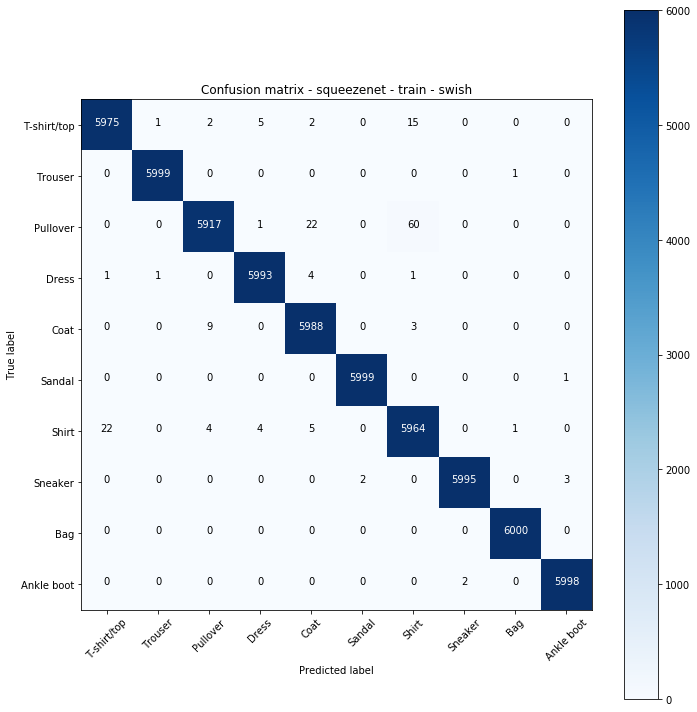

In [17]:
names_train = tuple(trainset.classes)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cmtr, names_train, title=f'Confusion matrix - {network} - train - {activation}', activation=activation, network=network, step='train')

### 7.2) Test Set

In [18]:
print(len(testset))
print(len(testset.targets))

10000
10000


In [19]:
with torch.no_grad():
    test_prediction_loader = torch.utils.data.DataLoader(testset, batch_size=1000)
    test_preds = get_all_preds(model, test_prediction_loader).to(device)

In [20]:
stacked_test = torch.stack(
    (
        testset.targets.to(device),
        test_preds.argmax(dim=1)
    ),dim=1
)

In [21]:
print(test_preds)
torch.save(test_preds, f'storage/results/test_preds_{network}_{activation}.pt')
# test_preds = torch.load(f'storage/benchmarks/cm/test_preds_{network}_{activation}.pt')

tensor([[ -8.4222,  -9.2493,  -9.6120,  ...,   0.7121, -18.3468,  22.3808],
        [-15.8081, -17.7402,  13.5391,  ..., -13.5520, -14.1479, -16.1083],
        [-25.8211,  32.9485, -26.8695,  ..., -15.4334,  -1.8417,  -9.6510],
        ...,
        [-25.2969, -11.1669, -21.5544,  ...,  -9.8537,  31.5990, -17.9837],
        [-22.3235,  22.8460,  -8.2508,  ...,  -9.3086, -14.9667, -11.7928],
        [ -7.0775, -11.1687,  -7.9996,  ...,  10.3896,   2.9301,  -6.4726]],
       device='cuda:0')


In [22]:
cmte = torch.zeros(10,10, dtype=torch.int64)
#cmt
for p in stacked_test:
    true, predicted = p.tolist()
    cmte[true, predicted] = cmte[true, predicted] + 1

Confusion matrix, without normalization
tensor([[875,   1,  20,  16,   3,   1,  78,   0,   6,   0],
        [  0, 990,   0,   7,   0,   0,   1,   0,   2,   0],
        [ 14,   1, 881,   8,  35,   0,  60,   0,   1,   0],
        [  8,   3,   6, 938,  23,   0,  21,   0,   1,   0],
        [  0,   0,  26,   9, 915,   0,  50,   0,   0,   0],
        [  0,   0,   0,   0,   0, 988,   0,   7,   0,   5],
        [ 86,   0,  31,  16,  59,   0, 802,   0,   6,   0],
        [  0,   0,   0,   0,   0,   7,   0, 975,   0,  18],
        [  2,   1,   0,   4,   1,   2,   1,   1, 988,   0],
        [  0,   0,   0,   0,   0,   3,   0,  22,   1, 974]])


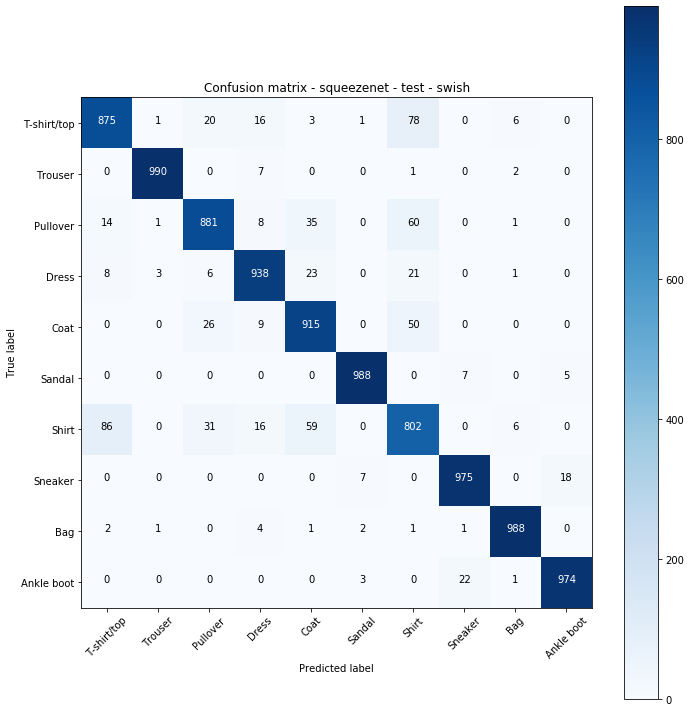

In [23]:
names_test = tuple(testset.classes)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cmte, names_test, title=f'Confusion matrix - {network} - test - {activation}', activation=activation, network=network, step='test')